## IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

## Load Data

In [2]:
df = pd.read_csv("MLTempDataset1.csv")

print("Info Data:")
print(df.info())
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7056 entries, 0 to 7055
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7056 non-null   int64  
 1   Datetime     7056 non-null   object 
 2   Hourly_Temp  7056 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 165.5+ KB
None
   Unnamed: 0             Datetime  Hourly_Temp
0           0  2022-01-04 00:00:00       20.867
1           1  2022-01-04 01:00:00       21.000
2           2  2022-01-04 02:00:00       20.867
3           3  2022-01-04 03:00:00       20.650
4           4  2022-01-04 04:00:00       20.400

Missing Values:
Unnamed: 0     0
Datetime       0
Hourly_Temp    0
dtype: int64


## Exploratory Data Analysis

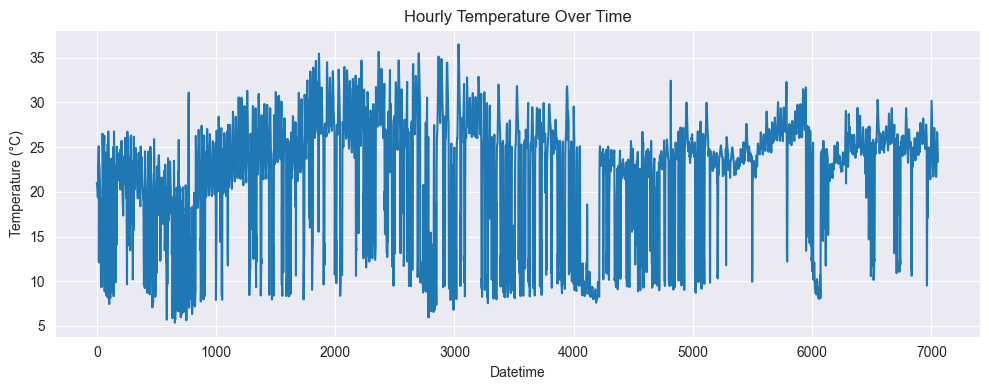

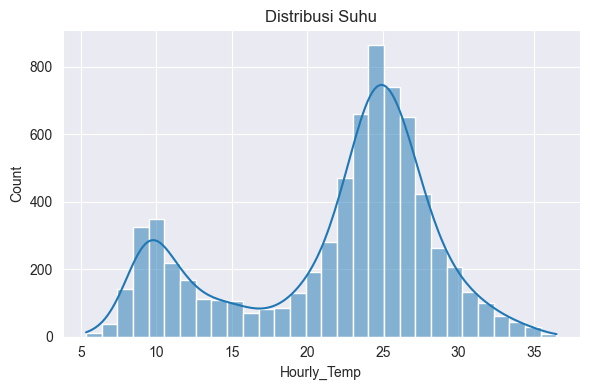

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(df['Hourly_Temp'])
plt.title("Hourly Temperature Over Time")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df['Hourly_Temp'], kde=True, bins=30)
plt.title("Distribusi Suhu")
plt.tight_layout()
plt.show()

## Preprocessing

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df[['Hourly_Temp']]

# === NORMALISASI ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# === WINDOWING ===
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(scaled_data, window_size)

# === SPLIT TRAIN TEST ===
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

## Modeling

In [5]:
model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

C:\Users\mrcah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training

In [6]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0750 - val_loss: 0.0085
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0178 - val_loss: 0.0058
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - val_loss: 0.0038
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0036
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0030
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - val_loss: 0.0040
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 9/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - val_loss: 0.0033
Epoch 10/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - val_loss: 0.0058


## Evaluasi

In [7]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
rse = np.sum((y_test_inv - y_pred_inv) ** 2) / np.sum((y_test_inv - np.mean(y_test_inv)) ** 2)

print(f"\nEvaluasi Model:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"RSE: {rse:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluasi Model:
RMSE: 1.71
MAE: 0.74
R²: 0.8703
RSE: 0.1297


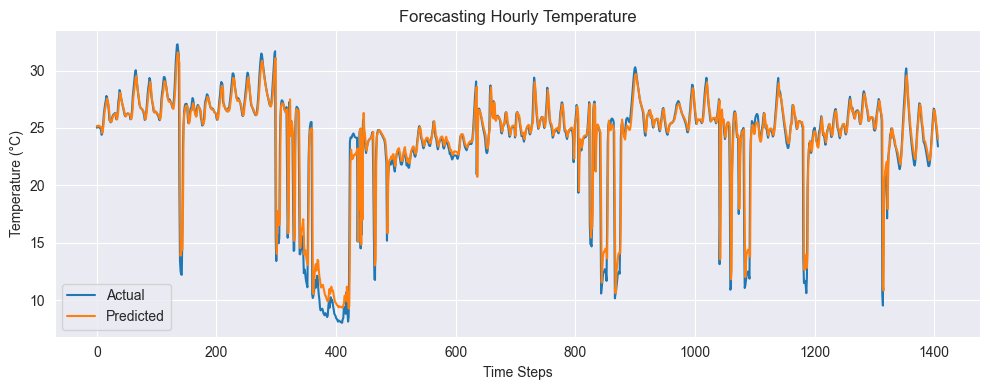

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Forecasting Hourly Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# === INFERENCE: Prediksi Suhu Beberapa Jam ke Depan ===
latest_sequence = scaled_data[-window_size:]
future_predictions = []

n_hours = 6
current_input = latest_sequence.reshape(1, window_size, 1)

for _ in range(n_hours):
    next_pred = model.predict(current_input)[0]
    future_predictions.append(next_pred)
    current_input = np.append(current_input[:, 1:, :], [[next_pred]], axis=1)

future_predictions_inv = scaler.inverse_transform(future_predictions)

# Gunakan waktu saat ini
now = datetime.now()
print(f"\nPrediksi suhu mulai dari waktu sekarang ({now.strftime('%Y-%m-%d %H:%M:%S')}):")
for i in range(n_hours):
    pred_time = now + pd.Timedelta(hours=i+1)
    pred_temp = future_predictions_inv[i][0]
    print(f"Perkiraan suhu pada {pred_time.strftime('%Y-%m-%d %H:%M:%S')} → {pred_temp:.2f} °C")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Prediksi suhu mulai dari waktu sekarang (2025-07-19 14:30:26):
Perkiraan suhu pada 2025-07-19 15:30:26 → 23.51 °C
Perkiraan suhu pada 2025-07-19 16:30:26 → 23.70 °C
Perkiraan suhu pada 2025-07-19 17:30:26 → 23.92 °C
Perkiraan suhu pada 2025-07-19 18:30:26 → 24.10 °C
Perkiraan suhu pada 2025-07-19 19:30:26 → 24.25 °C
Perkiraan suhu pada 2025-07-19 20:30:26 → 24.37 °C


## Save Model

In [9]:
# Ekspor model ke format SavedModel
model.export("saved_model_lstm_suhu")

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_lstm_suhu")

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Konversi model
tflite_model = converter.convert()

with open("model_lstm_suhu.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite dan disimpan.")


INFO:tensorflow:Assets written to: saved_model_lstm_suhu\assets


INFO:tensorflow:Assets written to: saved_model_lstm_suhu\assets


Saved artifact at 'saved_model_lstm_suhu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2055004429520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055004426448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055004426256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055004429904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2055004428752: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil dikonversi ke TFLite dan disimpan.


## Inference

In [10]:
# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model_lstm_suhu.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

latest_sequence = scaled_data[-window_size:]
input_data = latest_sequence.reshape(1, window_size, 1)

n_hours = 6
predictions = []

for _ in range(n_hours):
    interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    predictions.append(output[0])

    next_input = output.reshape(1, 1, 1)  # (1,1,1)
    input_data = np.append(input_data[:, 1:, :], next_input, axis=1)  # geser window

predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

now = datetime.now()
print(f"\nInference dari model TFLite (waktu sekarang: {now.strftime('%Y-%m-%d %H:%M:%S')}):")
for i, pred in enumerate(predictions_inv):
    waktu_prediksi = now + pd.Timedelta(hours=i+1)
    print(f"Perkiraan suhu pada {waktu_prediksi.strftime('%Y-%m-%d %H:%M:%S')} → {pred[0]:.2f} °C")


Inference dari model TFLite (waktu sekarang: 2025-07-19 14:28:28):
Perkiraan suhu pada 2025-07-19 15:28:28 → 23.51 °C
Perkiraan suhu pada 2025-07-19 16:28:28 → 23.70 °C
Perkiraan suhu pada 2025-07-19 17:28:28 → 23.92 °C
Perkiraan suhu pada 2025-07-19 18:28:28 → 24.10 °C
Perkiraan suhu pada 2025-07-19 19:28:28 → 24.25 °C
Perkiraan suhu pada 2025-07-19 20:28:28 → 24.37 °C


C:\Users\mrcah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
